In [2]:
import os
from pathlib import Path
os.environ["OMP_NUM_THREADS"] = "1"  # must be set before importing numpy/sklearn

import warnings
# Project path
BASE_PATH = Path.cwd()
print("Working in:", BASE_PATH)

# Warnings cleanup
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



Working in: C:\Users\andio\OneDrive\Desktop\University of Ottawa\September_2025_(fall)_Term\Research_DTI6997\Week_10


In [2]:
import pm4py
print(pm4py.__version__)


2.7.18


In [4]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

# Loading

In [9]:
log_path = BASE_PATH / "combined_event_log-filt_evt1p.csv"
# Load the CSV file into a DataFrame named 'log'
df = pd.read_csv(log_path)


C:\Users\andio\AppData\Local\Temp\ipykernel_6120\355878274.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(log_path)


In [10]:
df.head()

,Unnamed: 0,case:concept:name,time:timestamp,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name
0,0,0,2024-06-03 09:20:37.327,0,1-SQ1RI5F,NaN,Application Status,Prospective,Vietnam,Vietnam,Application Status - Prospective
1,1,0,2024-06-03 09:20:37.327,1,0,NaN,Misrepresentation,NIL,Vietnam,Vietnam,Misrepresentation - NIL
2,2,0,2024-06-03 09:20:37.327,1,0,NaN,Eligibility Assessment,NIL,Vietnam,Vietnam,Eligibility Assessment - NIL
3,3,0,2024-06-03 09:20:37.327,1,0,NaN,Final Assessment,NIL,Vietnam,Vietnam,Final Assessment - NIL
4,4,0,2024-06-03 09:20:37.327,1,0,NaN,Received,Date,Vietnam,Vietnam,Received - Date


In [11]:
# --- Step 1: Variability Metrics ---

# Total number of events
total_events = len(df)

# Total number of unique traces
total_traces = df['case:concept:name'].nunique()

# Construct variants: sequence of activities per case
variants = df.sort_values(['case:concept:name', 'time:timestamp']).groupby('case:concept:name')['concept:name'].apply(tuple)

# Number of unique variants
unique_variants = variants.nunique()

# Variability ratio
variability_ratio = unique_variants / total_traces if total_traces > 0 else 0

# --- Step 2: Activity Statistics ---

# Number of unique activities
unique_activities = df['activity'].nunique()

# Frequency of activities
activity_counts = df['activity'].value_counts()

# Most frequent activity
most_frequent_activity = activity_counts.idxmax()
most_frequent_count = activity_counts.max()

# Least frequent activity
least_frequent_activity = activity_counts.idxmin()
least_frequent_count = activity_counts.min()

# Average number of events per trace
events_per_trace = df.groupby('case:concept:name').size()
avg_events_per_trace = events_per_trace.mean()

# Summarize results
eda_summary = {
    "total_events": total_events,
    "total_traces": total_traces,
    "unique_variants": unique_variants,
    "variability_ratio": variability_ratio,
    "unique_activities": unique_activities,
    "most_frequent_activity": (most_frequent_activity, int(most_frequent_count)),
    "least_frequent_activity": (least_frequent_activity, int(least_frequent_count)),
    "avg_events_per_trace": avg_events_per_trace
}

eda_summary


{'total_events': 541096,
 'total_traces': 7734,
 'unique_variants': 7664,
 'variability_ratio': 0.990949056115852,
 'unique_activities': 33,
 'most_frequent_activity': ('Study Permit Fee', 34891),
 'least_frequent_activity': ('Identity Review', 197),
 'avg_events_per_trace': 69.96327902767003}

'# traces = 7734, # vars = 7664, ratio = 99.09'

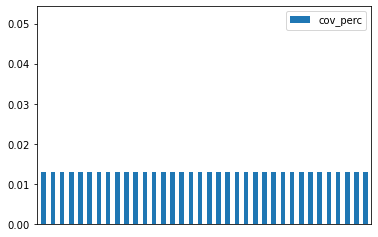

In [8]:
from variant_stats import get_variants_stats, get_variant_ratio, get_variant_coverage, filter_traces_on_variants

# get variant statistics

vars_stats = get_variants_stats(df)
vars_stats

variant_ratio = get_variant_ratio(df, vars_stats)
variant_ratio

In [9]:
# View which columns ahve missing values, and how many
df.isna().sum()

Unnamed: 0                0
case:concept:name         0
time:timestamp            0
act_upd_by                0
activity_id             127
group                498270
activity                  0
activity_status           0
cor                     366
citz                    366
concept:name              0
dtype: int64

# Cleaning

In [6]:
# 1. Convert timestamp to datetime (i.e. valid timestamp for PM)
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], errors='coerce')

# 2. Sequence of activities determines the process model and its variants,
#    sorting ensures that the process graph is constructed accurately
df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

# 3. Drop rows missing essential process mining attributes
required_cols = ['case:concept:name', 'concept:name', 'time:timestamp']
df = df.dropna(subset=required_cols)

# 4. Replace missing inputs in string columns with "Missing"
#    (useful if there are non-core columns with missing values)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna("Missing")

# 5. Replace spaces in the 'concept:name' column with underscores
#    This ensures activity labels are standardized (e.g. for PM4Py)
df['concept:name'] = df['concept:name'].str.replace(' ', '_', regex=False)

# 6. Drop the unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])


In [7]:
# View which columns ahve missing values, and how many
df.isna().sum()

# Note: At this point, all we've done is put the string "Missing" anywehre there was an empty
#         cell (for both core and additional columns)

case:concept:name    0
time:timestamp       0
act_upd_by           0
activity_id          0
group                0
activity             0
activity_status      0
cor                  0
citz                 0
concept:name         0
dtype: int64

In [10]:
df.head()

,case:concept:name,time:timestamp,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name
0,0,2024-06-03 09:20:37.327,0,1-SQ1RI5F,Missing,Application Status,Prospective,Vietnam,Vietnam,Application_Status_-_Prospective
1,0,2024-06-03 09:20:37.327,1,0,Missing,Misrepresentation,NIL,Vietnam,Vietnam,Misrepresentation_-_NIL
2,0,2024-06-03 09:20:37.327,1,0,Missing,Eligibility Assessment,NIL,Vietnam,Vietnam,Eligibility_Assessment_-_NIL
3,0,2024-06-03 09:20:37.327,1,0,Missing,Final Assessment,NIL,Vietnam,Vietnam,Final_Assessment_-_NIL
4,0,2024-06-03 09:20:37.327,1,0,Missing,Received,Date,Vietnam,Vietnam,Received_-_Date


In [13]:
# --- Step 1: Variability Metrics ---

# Total number of events
total_events = len(df)

# Total number of unique traces
total_traces = df['case:concept:name'].nunique()

# Construct variants: sequence of activities per case
variants = df.sort_values(['case:concept:name', 'time:timestamp']).groupby('case:concept:name')['concept:name'].apply(tuple)

# Number of unique variants
unique_variants = variants.nunique()

# Variability ratio
variability_ratio = unique_variants / total_traces if total_traces > 0 else 0

# --- Step 2: Activity Statistics ---

# Number of unique activities
unique_activities = df['activity'].nunique()

# Frequency of activities
activity_counts = df['activity'].value_counts()

# Most frequent activity
most_frequent_activity = activity_counts.idxmax()
most_frequent_count = activity_counts.max()

# Least frequent activity
least_frequent_activity = activity_counts.idxmin()
least_frequent_count = activity_counts.min()

# Average number of events per trace
events_per_trace = df.groupby('case:concept:name').size()
avg_events_per_trace = events_per_trace.mean()

# Summarize results
eda_summary = {
    "total_events": total_events,
    "total_traces": total_traces,
    "unique_variants": unique_variants,
    "variability_ratio": variability_ratio,
    "unique_activities": unique_activities,
    "most_frequent_activity": (most_frequent_activity, int(most_frequent_count)),
    "least_frequent_activity": (least_frequent_activity, int(least_frequent_count)),
    "avg_events_per_trace": avg_events_per_trace
}

eda_summary


{'total_events': 541096,
 'total_traces': 7734,
 'unique_variants': 7664,
 'variability_ratio': 0.990949056115852,
 'unique_activities': 33,
 'most_frequent_activity': ('Study Permit Fee', 34891),
 'least_frequent_activity': ('Identity Review', 197),
 'avg_events_per_trace': 69.96327902767003}

'# traces = 7734, # vars = 7664, ratio = 99.09'

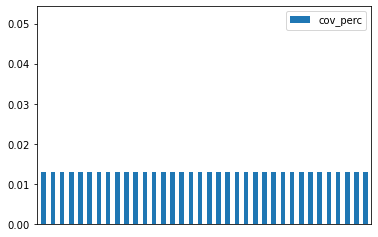

In [14]:
from variant_stats import get_variants_stats, get_variant_ratio, get_variant_coverage, filter_traces_on_variants

# get variant statistics

vars_stats = get_variants_stats(df)
vars_stats

variant_ratio = get_variant_ratio(df, vars_stats)
variant_ratio

## Saving Data with no missing or Nans

In [17]:
# Suppose your dataframe is called df
df.to_csv("combined_event_log-filt_evt1p_no_nans_values.csv", index=False)


In [15]:
# Widget libraries
from ipywidgets import interact
import ipywidgets as widgets

# Get unique case IDs
cases = df['case:concept:name'].unique()

# 🧭 Interactive function to view case data
@interact
def getCaseData(case_id=widgets.Dropdown(options=cases, description='Case ID:')):
    display(df[df['case:concept:name'] == case_id])


interactive(children=(Dropdown(description='Case ID:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

In [16]:
# Show datatypes of all columns
print(df.dtypes)


case:concept:name             int64
time:timestamp       datetime64[ns]
act_upd_by                    int64
activity_id                  object
group                        object
activity                     object
activity_status              object
cor                          object
citz                         object
concept:name                 object
dtype: object


In [20]:
case_0_count = df[df['case:concept:name'] == 0].shape[0]
case_0_count

78

In [9]:
case_353_count = df[df['case:concept:name'] == 353].shape[0]
case_353_count


63

In [12]:
num_unique_cases = df['case:concept:name'].nunique()
print("Number of unique cases:", num_unique_cases)


Number of unique cases: 7734


# Sampling the data

In [16]:
# 1️⃣ Get all unique case IDs
unique_case_ids = df['case:concept:name'].drop_duplicates()

# 2️⃣ Randomly sample 75 unique case IDs
sampled_case_ids = unique_case_ids.sample(n=500, random_state=42)

# 3️⃣ Subset the dataframe to only rows where the case ID is one of the sampled IDs
df_sample = df[df['case:concept:name'].isin(sampled_case_ids)].copy()

# 4️⃣ Sort by case ID and timestamp (recommended for trace analysis)
df_sample = df_sample.sort_values(['case:concept:name', 'time:timestamp'])

# 5️⃣ Save the sampled dataframe to CSV
output_file = "df_sampled_500_cases.csv"
df_sample.to_csv(output_file, index=False)

# 6️⃣ Double-check sample details
print(f"✅ File saved as: {output_file}")
print(f"✅ Sampled unique case IDs: {df_sample['case:concept:name'].nunique()}")
print(f"✅ Total events in sample: {len(df_sample)}")


✅ File saved as: df_sampled_500_cases.csv
✅ Sampled unique case IDs: 500
✅ Total events in sample: 34827


In [23]:
df_sample.head()

,case:concept:name,time:timestamp,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name
24299,353,2024-06-03 13:40:41.770,0,1-SQAAN5X,Missing,Application Status,Prospective,Guinea,Guinea,Application_Status_-_Prospective
24300,353,2024-06-03 13:40:41.770,1,0,Missing,Misrepresentation,NIL,Guinea,Guinea,Misrepresentation_-_NIL
24301,353,2024-06-03 13:40:41.770,1,0,Missing,Eligibility Assessment,NIL,Guinea,Guinea,Eligibility_Assessment_-_NIL
24302,353,2024-06-03 13:40:41.770,1,0,Missing,Final Assessment,NIL,Guinea,Guinea,Final_Assessment_-_NIL
24303,353,2024-06-03 13:40:41.770,1,0,Missing,Received,Date,Guinea,Guinea,Received_-_Date


In [10]:
case_353_count = df_sample[df_sample['case:concept:name'] == 353].shape[0]
case_353_count

# if this number mathces the same nmber wehen this code ran on the original data 
#  set(for the same case),then we can be confident that samples contain a case and ALL its 
#  assosciated events

63

'# traces = 10, # vars = 10, ratio = 100.0'

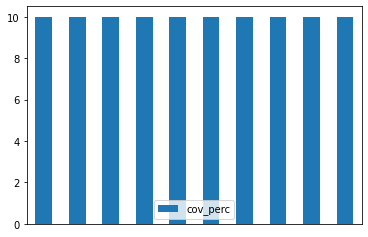

In [26]:
# get variant statistics

vars_stats = get_variants_stats(df_sample)
vars_stats

variant_ratio = get_variant_ratio(df_sample, vars_stats)
variant_ratio